# Python imports

In [1]:
%matplotlib inline

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# make xrange available in python3
try:
    xrange = xrange
except NameError:
    xrange = range

# Create some toy classification tasks

Let's create some toy classification task for our experiments.
We randomly create a 2D dataset and set different target variables (i.e., tasks).

In [3]:
# fix a seed for the random number generator
np.random.seed(0)

# create a 2D dataset composed of points normally distributed around (0, 1) with a standard deviation of (0.75, 1.5) along the two axis
dataset_size = 500
dataset_mean = (0, 5)
dataset_std = (0.75, 1.5)
X = np.random.normal(loc=dataset_mean, scale=dataset_std, size=(dataset_size, 2))
# ys is the list of labels used by the different tasks
ys = []


# first task: the label is 1 when the point is above the diagonal (passing for the dataset mean point)
ys.append(
    1.0 * ((X[:,0]-dataset_mean[0]) <= (X[:,1]-dataset_mean[1]))
)
# second task: the label is 1 when the point is in the upper left quadrant
ys.append(
    1.0 * (((X[:,0]-dataset_mean[0]) <= 0) & ((X[:,1]-dataset_mean[1]) >= 0))
)
# third task: the label is 1 when the X[1] is above the cosine of X[0]
ys.append(
    1.0 * (np.cos((X[:,0]-dataset_mean[0])) <= (X[:,1]-dataset_mean[1]))
)
# fourth task: the label is 1 when the point has a distance from the origin less or equal to 1.0
ys.append(
    1.0 * (np.sqrt((X[:,0]-dataset_mean[0])**2 + (X[:,1]-dataset_mean[1])**2) <= 1.0)
)

Plot the dataset with regards the tasks using scatter plots

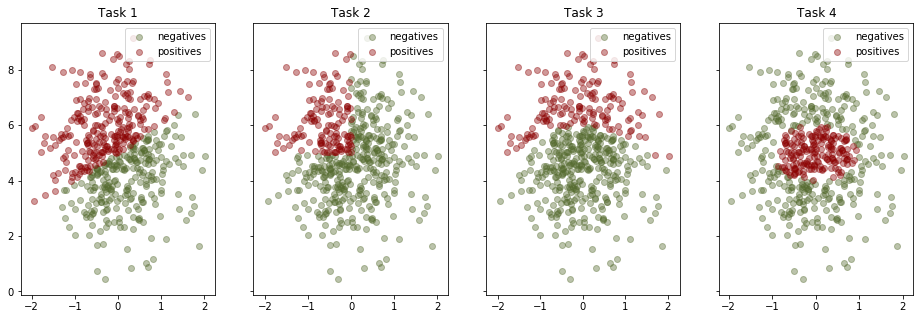

In [4]:
plt_cmap = mpl.colors.ListedColormap(['darkolivegreen', 'darkred'])
def plot_dataset(X, y_true, ax=None, prefix="", suffix="", legend=True):
    if ax is None:
        ax = plt
    # plot the points having class 0, then the ones having class 1
    where = (y_true == 0)
    ax.scatter(X[:,0][where], X[:,1][where], c=plt_cmap.colors[0], alpha=0.4, label=prefix+"negatives"+suffix)
    where = (y_true == 1)
    ax.scatter(X[:,0][where], X[:,1][where], c=plt_cmap.colors[1], alpha=0.4, label=prefix+"positives"+suffix)
    # show the legend
    if legend:
        ax.legend(loc='upper right')

fig, axs = plt.subplots(ncols=len(ys), figsize=(16,5), sharey=True)
for i, y in enumerate(ys):
    axs[i].set_title("Task {}".format(i+1))
    plot_dataset(X, ys[i], ax=axs[i])
plt.show()

We must normalize the features in order to train the Neural Network.

Therefore, we normalize the dataset using standardization: $(X - mean(X)) / std(X)$.

In [5]:
def normalize(X):
    return (X - X.mean(axis=0)) / X.std(axis=0)

X_normalized = normalize(X)

# Let's start with a simple Neural Network composed of just one layer

Let $W$ and $b$ be the weights matrix and the bias vector of the first layer, respectively. We define them with a function:

In [6]:
def get_weights_and_bias(input_size, output_size, seed=None):
    if seed is not None:
        np.random.seed(seed)

    W = np.random.randn(input_size, output_size)
    b = np.random.randn(output_size)
    # we reduce the value of the weights proportionally to the number of weights or biases impacting each node
    W *= np.sqrt(2.0 / (input_size + output_size))
    b *= np.sqrt(2.0 / (input_size + output_size))

    return W, b

In the following we use the sigmoid activation function to implement our Neural Network.

The sigmoid activation function is defined as
$\sigma(x) = \frac{1}{1 + e^{-x}}$.

Its derivative (we will use it later) is 
$\sigma'(x) = \sigma(x) (1 - \sigma(x))$.

The output of the Neural Network is
$\hat{y} = \sigma(W x + b)$.

Let's define a feed-forward function implementing this logic.

In [7]:
def sigmoid(x):
    return 1.0 / (1.0 + np.exp(-np.clip(x, -50, 50)))
sigmoid.derivative = lambda x, y: y * (1.0 - y)

def feedforward(X, W, b, activation_function):
    # the following code is equivalent to perform `activation(Wx+b)` for each example
    return activation_function(np.matmul(X, W) + b)

Let us consider the binary cross entropy loss to address the classification task, which is defined as:
$$l(y, \hat{y}) = - y \cdot \log(\hat{y}) - (1-y) \cdot \log(1-\hat{y})$$

To optimize a specific loss we need to study the impact of each weight and bias on the final error, hence we need to derive the error with respect to the Neural Network parameters.

We start by implementing the binary cross entropy loss and its derivative. The derivative of the binary cross entropy is:
$$\frac{\delta l(y, \hat{y})}{\delta \hat{y}} = \frac{\hat{y} - y}{\hat{y} - \hat{y}^2}$$

In the following, $\hat{y}$ is `y_pred` and $y$ is `y_true`.

In [8]:
def binary_cross_entropy_loss(y_true, y_pred, epsilon=1e-15):
    # add an axis to y_true to match the shapes: y_pred is a matrix with `n` rows and one column
    y_true = y_true[:, np.newaxis]
    # the following constraint is used to avoid problems with the log function
    y_pred = np.minimum(np.maximum(y_pred, epsilon), 1.0-epsilon)
    # if y_true and y_pred are vectors the result is a vector containing the loss of each example
    return -(y_true * np.log(y_pred) + (1.0 - y_true) * np.log(1.0 - y_pred))
binary_cross_entropy_loss.derivative = lambda y_true, y_pred: (y_pred - y_true[:, np.newaxis]) / np.maximum(1e-15, y_pred - y_pred**2)

Let $E$ be the error of the NN. It is defined as the mean of the losses over all training examples, i.e.,
$$E(y, \hat{y}) = \frac{1}{n} \sum_{i=1}^{n} l(y_i, \hat{y_i})$$

The derivatives of the error with respect to weights and biases can be used to apply optimization methods, like stochastic gradient descent as shown below, to find (hopefully) the best neural network parameters. Indeed, the derivatives indicates how the error changes by increasing/decreasing (locally) each one of the neural network parameters.

The derivatives can be obtained by applying the (derivative) chain rule as follows:
$$\frac{\delta}{\delta w} E(y, \hat{y})
= \frac{1}{n} \sum_{i=1}^{n}
      \frac{\delta l(y_i, \hat{y_i})}{\delta \sigma(W x_i + b)}
\cdot \frac{\delta \sigma(W x_i + b)}{\delta W x_i + b}
\cdot \frac{\delta W x_i + b}{\delta W x_i}
\cdot \frac{\delta W x_i}{\delta W}$$

The **first term** of the summation is the derivative of the binary cross entropy loss and the **second one** is the derivative of the sigmoid function.
The **third term** is $1$, hence it can be ignored, while the **last term** is $x_i$.

Instead, the derivative of the error with respect to the bias, i.e., $\frac{\delta}{\delta b} E(y, \hat{y})$, differs just for the last two terms of the summation. In particular, they are replaced by the following:
$\frac{\delta W x_i + b}{\delta b} = 1$.

To conclude, the computation of the gradient (the derivative of the error with respect to the several weights and biases) can be performed by computing the error and then by backpropagating this error by deriving the single components involved.

![Backpropagation](img/backpropagation.png)
Image source: [becominghuman.ai](https://becominghuman.ai/back-propagation-in-convolutional-neural-networks-intuition-and-code-714ef1c38199)

To this end, let's define a backpropagation function implementing this logic.

In [9]:
def backpropagate(X, W, b, activation_function, output_error_derivative, learning_rate=0.01):
    # compute the layer input
    layer_input = np.matmul(X, W) + b
    layer_output = activation_function(layer_input)
    # compute the deltas
    delta = output_error_derivative * activation_function.derivative(layer_input, layer_output)
    # add the fourth term to compute the update of the weights
    weight_update = np.matmul(X.T, delta)
    # just sum-up all deltas to compute the update of the bias
    bias_update = np.sum(delta, axis=0)

    # update weights and biases
    W -= learning_rate * weight_update
    b -= learning_rate * bias_update

    # return the gradient with respect to the input parameters
    return np.matmul(delta, W.T)

Now we define the train function used to train our Neural Network.
The training consists of alternating the following two steps for a certain number of epochs: i) a forward step to compute the actual error and ii) a backward step which propagates back the actual error over the weights and the bias.

In [10]:
def train_one_layer_NN(X, y, num_epochs=1, learning_rate=0.01, callbacks=[], seed=None):
    assert X.shape[0] == y.shape[0]
    assert isinstance(num_epochs, int) and num_epochs > 0
    assert isinstance(learning_rate, float) and learning_rate > 0
    assert hasattr(callbacks, "__iter__") and all(hasattr(callback, "__call__") for callback in callbacks)

    # init the neural network parameters
    W, b = get_weights_and_bias(input_size=X.shape[1], output_size=1, seed=seed)

    # put them into two tuples to make this code compatible with the functions defined below
    # each tuple contains number_of_layers weights/biases. In this case the number of layers is 1.
    NN = ((W,), (b,))

    # training epochs
    for epoch in xrange(1, num_epochs+1):
        y_pred = feedforward(X, W, b, sigmoid)

        # the callbacks can be used to monitor the training
        for callback in callbacks:
            callback(y, y_pred)

        # compute the error derivative. Here we must include the term 1 over n
        error_derivative = binary_cross_entropy_loss.derivative(y, y_pred) / X.shape[0]

        # backpropagate the error
        backpropagate(X, W, b, sigmoid, error_derivative, learning_rate=learning_rate)

    return NN

Here, we define a function to test the Neural Network training. It is "general-purpose" to reuse it with multiple layers. It just calls the training function with the given parameters and does some plots.

In [11]:
def feedforward_all(X, Ws, bs, activation_functions):
    assert len(Ws) == len(bs) == len(activation_functions)
    y_pred = X
    for l in xrange(len(activation_functions)):
        y_pred = feedforward(y_pred, Ws[l], bs[l], activation_functions[l])
    return y_pred

def test_training(X, ys, training_function, training_parameters={}):
    fig, axs = plt.subplots(nrows=2, ncols=len(ys), figsize=(16,10), sharey="row")

    # create a grid to plot the neural network contour: https://matplotlib.org/api/_as_gen/matplotlib.pyplot.contour.html
    gridx = 1000
    x0i = np.linspace(X[:,0].min(), X[:,0].max(), gridx)
    x1i = np.linspace(X[:,1].min(), X[:,1].max(), gridx)
    X0i, X1i = np.meshgrid(x0i, x1i)
    Xi = np.vstack([X0i.flatten(), X1i.flatten()]).T

    # train over the several tasks
    for i, y in enumerate(ys):
        # store in a list all losses met during the training
        loss_hist = []
        def fill_loss_hist(y_true, y_pred):
            loss_hist.append(binary_cross_entropy_loss(ys[i], y_pred).mean())

        # train the Neural Network
        Ws, bs = training_function(
            X,
            ys[i],
            callbacks=[fill_loss_hist],
            seed=0,
            **training_parameters
        )

        # compute the loss at the end of the training
        activation_functions = [sigmoid] * len(Ws)
        if "activation_functions" in params:
            activation_functions = params["activation_functions"]
        y_pred = feedforward_all(X, Ws, bs, activation_functions)
        fill_loss_hist(ys[i], y_pred)

        # plot the loss history
        axs[0, i].plot(loss_hist)
        axs[0, i].set_xlabel("Num epochs")
        if i == 0:
            axs[0, i].set_ylabel("Error")
            axs[0, i].set_ylim((0, None))

        # plot the predictions
        # predict the points of the grid
        zi = feedforward_all(Xi, Ws, bs, activation_functions).reshape(X0i.shape)
        # plot the surface
        axs[1,i].contourf(X0i, X1i, zi, levels=np.linspace(0,1,10), cmap=plt_cmap, alpha=0.1)
        # plot the points
        plot_dataset(X, y, ax=axs[1,i], legend=False)
        # enable the following line to plot the predictions of the model
        #plot_dataset(X, np.round(y_pred.flatten()), ax=axs[1,i], prefix="pred. ")
        # plot the delimiter line
        axs[1,i].contour(X0i, X1i, zi, levels=[0.5], linewidths=0.5, colors='k')
    plt.show()

Fit the neural network on each task and show how the loss changes during the training, and the predictions over all datasets.

/Users/tranir/miniconda2/lib/python2.7/site-packages/matplotlib/contour.py:1180: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


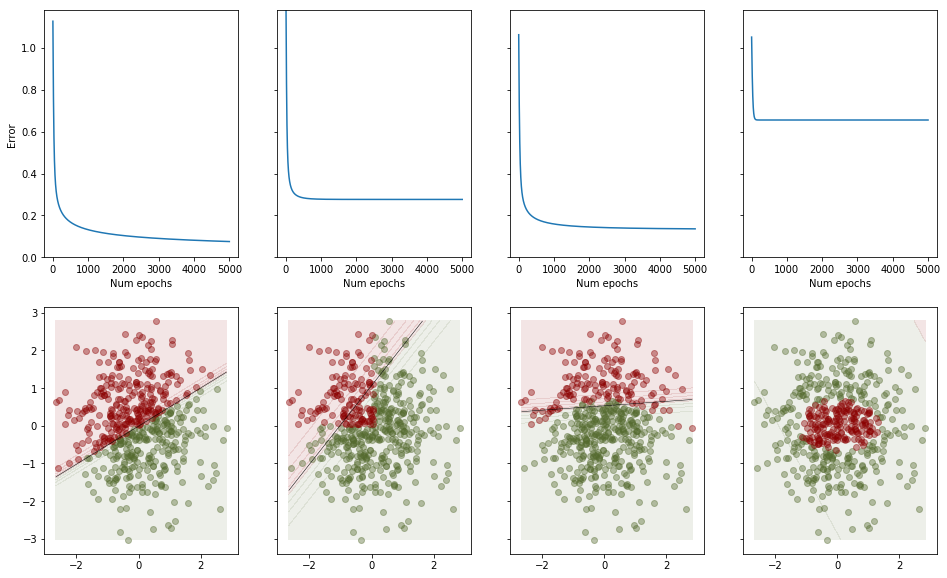

In [12]:
params = {
    "num_epochs": 5000,
    "learning_rate": 0.1
}
test_training(X_normalized, ys, train_one_layer_NN, params)

The last task is more difficult than the previous ones because it does not exist an hyperplane cutting the hyperspace able to separate positive and negative examples. Therefore, a one layer Neural Network is not able to separate the two classes.

# Let's extend the previous Neural Network with an additional layer

Let's define the train function used to train our Neural Network.

The training consists of:
 1. forwarding the input through the Neural Network to compute the error 
 2. backpropagating the error layer by layer. The following image shows this process.

![Backpropagation 2 layers](img/backpropagation2layers.png)
Image source: [towardsdatascience.com](https://towardsdatascience.com/how-to-build-your-own-neural-network-from-scratch-in-python-68998a08e4f6)

In [13]:
def train_two_layer_NN(X, y, hidden_layer_size, num_epochs=1, learning_rate=0.01, callbacks=[], seed=None):
    assert X.shape[0] == y.shape[0]
    assert isinstance(hidden_layer_size, int) and hidden_layer_size > 0
    assert isinstance(num_epochs, int) and num_epochs > 0
    assert isinstance(learning_rate, float) and learning_rate > 0
    assert hasattr(callbacks, "__iter__") and all(hasattr(callback, "__call__") for callback in callbacks)

    # init the neural network parameters
    W1, b1 = get_weights_and_bias(input_size=X.shape[1], output_size=hidden_layer_size, seed=seed)
    W2, b2 = get_weights_and_bias(input_size=hidden_layer_size, output_size=1, seed=seed)

    NN = ((W1, W2), (b1, b2))

    # training epochs
    for epoch in xrange(1, num_epochs+1):
        layer1_pred = feedforward(X, W1, b1, sigmoid)
        y_pred = feedforward(layer1_pred, W2, b2, sigmoid)

        # the callbacks can be used to monitor the training
        for callback in callbacks:
            callback(y, y_pred)

        # compute the error derivative. Here we must include the term 1 over n
        error_derivative = binary_cross_entropy_loss.derivative(y, y_pred) / X.shape[0]

        # backpropagate the error
        layer1_error_derivative = backpropagate(layer1_pred, W2, b2, sigmoid, error_derivative, learning_rate=learning_rate)
        backpropagate(X, W1, b1, sigmoid, layer1_error_derivative, learning_rate=learning_rate)

    return NN

Fit the neural network on each task using an hidden layer of size $10$ and show how the loss changes during the training, and the predictions over all datasets.

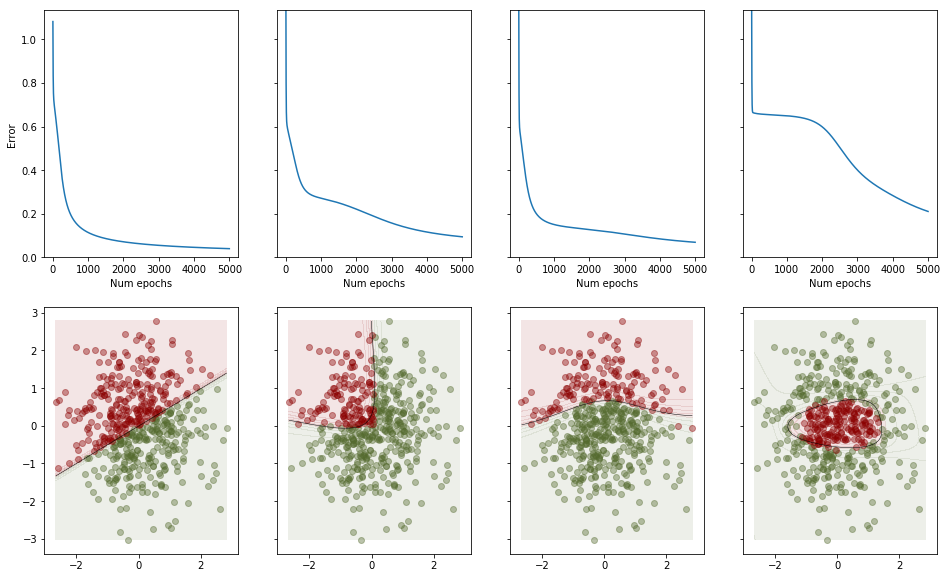

In [14]:
params = {
    "num_epochs": 5000,
    "learning_rate": 0.1,
    "hidden_layer_size": 10
}
test_training(X_normalized, ys, train_two_layer_NN, params)

# Let's extend these concepts to the general case:
## parametric activation functions, number of hidden layers and loss function

In [15]:
def train_NN(
    X,
    y,
    loss_function=binary_cross_entropy_loss,
    hidden_layer_sizes=[1],
    activation_functions=[sigmoid],
    num_epochs=1,
    learning_rate=0.01,
    callbacks=[],
    seed=None
):
    assert X.shape[0] == y.shape[0]
    assert hasattr(loss_function, "__call__") and hasattr(loss_function, "derivative") and hasattr(loss_function.derivative, "__call__")
    assert hasattr(hidden_layer_sizes, "__iter__") and all(isinstance(size, int) and size > 0 for size in hidden_layer_sizes) and hidden_layer_sizes[-1] == 1
    assert hasattr(activation_functions, "__iter__") and len(activation_functions) == len(hidden_layer_sizes) and all(hasattr(f, "__call__") and hasattr(f, "derivative") and hasattr(f.derivative, "__call__") for f in activation_functions)
    assert isinstance(num_epochs, int) and num_epochs > 0
    assert isinstance(learning_rate, float) and learning_rate > 0
    assert hasattr(callbacks, "__iter__") and all(hasattr(callback, "__call__") for callback in callbacks)

    n_layers = len(hidden_layer_sizes)
    
    # init the neural network parameters
    Ws = [None] * n_layers
    bs = [None] * n_layers

    sizes = [X.shape[1]] + hidden_layer_sizes
    for i in xrange(n_layers):
        Ws[i], bs[i] = get_weights_and_bias(
            input_size=sizes[i],
            output_size=sizes[i+1],
            seed=seed
        )

    # just to make the lists unmodifiable
    Ws, bs = tuple(Ws), tuple(bs)
    NN = (Ws, bs)

    # training epochs
    for epoch in xrange(1, num_epochs+1):
        layers_pred = [None] * n_layers
        layers_pred[-1] = X  # this is just a trick to make layers_pred[0-1] = X when the following loop starts
        for i in xrange(n_layers):
            layers_pred[i] = feedforward(layers_pred[i-1], Ws[i], bs[i], activation_functions[i])

        # the callbacks can be used to monitor the training
        for callback in callbacks:
            callback(y, layers_pred[-1])

        # compute the error derivative. Here we must include the term 1 over n
        error_derivatives = [None] * n_layers
        error_derivatives[-1] = loss_function.derivative(y, layers_pred[-1]) / X.shape[0]

        # backpropagate the error
        for i in xrange(n_layers-1, 0, -1):
            error_derivatives[i-1] = backpropagate(layers_pred[i-1], Ws[i], bs[i], activation_functions[i], error_derivatives[i], learning_rate=learning_rate)
        backpropagate(X, Ws[0], bs[0], activation_functions[0], error_derivatives[0], learning_rate=learning_rate)

    return NN

We define the ReLU activation function, which is defined as: $relu(x) = max(0, x)$

In [16]:
def relu(x):
    return np.maximum(0, x)
# the following function has two parameters (input and output of the relu function) because this is the signature used in the code.
relu.derivative = (lambda x, y: 1.0 * (x > 0))

Fit the neural network on each task using two hidden layers of size $50$ and $10$, respectively. The activation functions used are relu, sigmoid and sigmoid (for the output layer). Lastly, we show how the loss changes during the training, and the predictions over all datasets

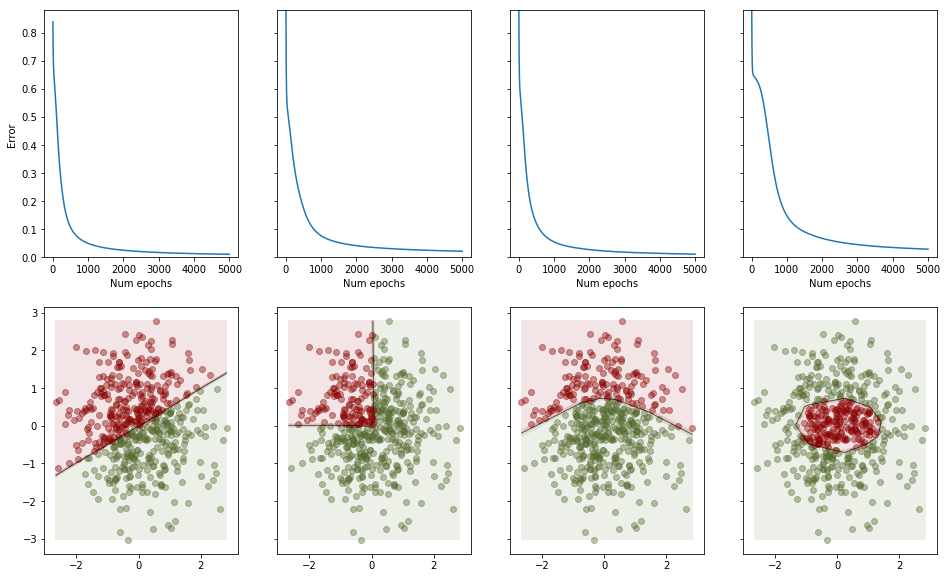

In [17]:
params = {
    "num_epochs": 5000,
    "learning_rate": 0.1,
    "loss_function": binary_cross_entropy_loss,
    "hidden_layer_sizes": [10, 5, 1],
    "activation_functions": [relu, sigmoid, sigmoid],
}
test_training(X_normalized, ys, train_NN, params)